In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

c:\Users\gemin\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\gemin\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\gemin\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os
path = os.environ.get("DATASET_PATH")
if path is None:
    path = "./data"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 1024
image_size = 12

In [4]:
## Ready for dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((image_size, image_size))])
# transform = transforms.Compose([transforms.ToTensor()])

class MNISTDataset(Dataset):
    def __init__(self, transform):
        super().__init__()
        dataset = MNIST(path, download=True, transform=transform)
        self.data = [data.flatten() for data, _ in dataset]
    
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
    

dataset = MNISTDataset(transform)
# load the dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

c:\Users\gemin\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


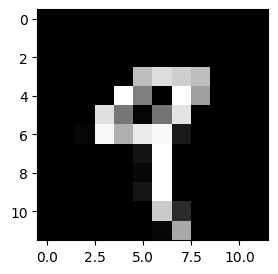

In [5]:
# load the dataset
idx = 4
img = dataset[idx].numpy().reshape(image_size, image_size)
plt.figure(figsize=(3,3))
plt.imshow(img, cmap="gray")

## Forward process

In [6]:
def plot_process(xs):
    N = len(xs)
    # show the result of forward process
    plt.figure(figsize=((N)*2, 3),)
    for i in range(N):
        ax = plt.subplot(1, N, 1+i)
        ax.set_axis_off()
        ax.imshow(xs[i].numpy(), cmap='gray')

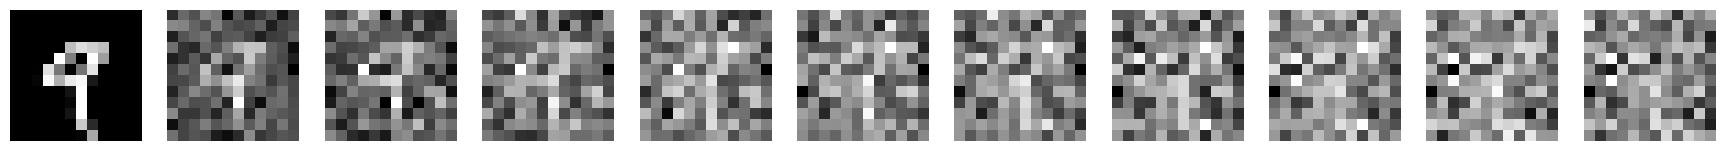

In [7]:
def forward_process(x0, T, betas):
    datas = [x0]
    x = x0
    for t in range(T):
        # Gaussian diffusion 
        x = x* torch.sqrt(1 - betas[t]) + torch.sqrt(betas[t]) * torch.randn_like(x) # x * mu + std * eps
        datas.append(x)
    return datas

# num of steps
T = 10
betas = torch.tensor([0.08]*T)
x0 = torch.Tensor(img)
xs = forward_process(x0, T, betas)

# plot the images
plot_process(xs)

## Varations of betas

In [8]:
import math
def create_betas(steps:int, start, end, type="linear"):
    betas = None
    if type == "linear":
        betas = torch.linspace(start, end, steps)
    elif type == "power":
        betas = torch.linspace(math.sqrt(start), math.sqrt(end), steps)**2
    elif type == "sigmoid":
        betas = torch.sigmoid(torch.linspace(-10, 8, steps))*(end-start) + start
    return betas

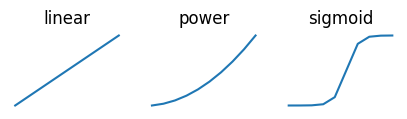

In [9]:
betas = (create_betas(10, 1e-4, 0.02, 'linear'), 'linear'), (create_betas(10, 1e-4, 0.02, 'power'), 'power'), (create_betas(10, 1e-4, 0.02, 'sigmoid'), 'sigmoid')

def plot_betas(betas):
    fig, axs = plt.subplots(1, len(betas), figsize=(5, 1))
    for i in range(len(betas)):
        axs[i].plot(betas[i][0])
        axs[i].set_title(betas[i][1])
        axs[i].set_axis_off()
    plt.show()

plot_betas(betas)


## Backward process

In [10]:
class MLPNet(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_steps):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_steps = num_steps
        self.prenet = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU())
        self.nets =  nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim*2)) for _ in range(self.num_steps)])

    def forward(self, x, t):
        """Return mu, log_var"""
        x = self.nets[t](self.prenet(x))
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var


class MLPModel(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_steps):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_steps = num_steps

        self.emb_1 = nn.Embedding(num_steps, latent_dim)
        self.emb_2 = nn.Embedding(num_steps, hidden_dim)
        self.prenet = nn.Sequential(
            nn.Linear(latent_dim, latent_dim), nn.LeakyReLU()
        )
        self.nets_1 = self.postnet =  nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim))
        self.nets_2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim*2))

    def forward(self, x, t):
        if not torch.is_tensor(t):
            t = torch.tensor([t]).to(x.device).long()
        emb1 = self.emb_1(t)
        emb2 = self.emb_2(t)
        x = self.nets_1(self.prenet(x)*emb1)
        x = self.nets_2(x*emb2)
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var

class DecoderNet(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim), nn.Tanh(),
        )

    def forward(self, x):
        x = self.model(x) # [batch_size, latent_dim] -> [batch_size, latent_dim]
        # -1.0 ~ 1.0 -> 0.0 ~ 1.0
        return (x+1.0) / 2.0



def plot_imgs(imgs, img_size, size, scores=None, save_file=None):
    imgs = imgs.view(-1, img_size, img_size)
    f, axarr = plt.subplots(size[0], size[1], figsize=(4, 4))
    for i in range(size[1]):
        for j in range(size[0]):
            idx = i*size[0]+j
            axarr[i, j].imshow(imgs[idx,:].numpy(), cmap='gray')
            axarr[i, j].set_axis_off()

            # only for discriminator
            if scores is not None:
                axarr[i,j].text(0.0, 0.5, str(round(scores[idx], 2)), dict(size=20, color='red'))

    if save_file is not None:
        plt.savefig(save_file)
    plt.show()

In [11]:
def reparameterize(mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return mu + std*eps

def backward_process(z0, model, T):
    zs = [z0]
    zt = z0
    for t in range(T-1, -1, -1):
        mu, log_var = model(zt, t)
        zt = reparameterize(mu, log_var)
        zs.append(z0)
    return zs


latent_dim=image_size*image_size
hidden_dim=256

z0 = torch.randn(4, latent_dim)
model = MLPNet(latent_dim, hidden_dim, T)

### TODO:  will load later

## Model implementations

In [12]:
# http://jrmeyer.github.io/machinelearning/2017/08/18/mle.html
def log_likelihood_of_gaussian(x, mu, log_var):
    log_p = -(0.5 * torch.tensor(2. * torch.pi).to(x.device).log_() + log_var) - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    return log_p

class DiffusionModel(nn.Module):
    def __init__(self, latent_dim:int, hidden_dim:int, ModelNet, DecoderNet, betas, device='cpu'):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.T = len(betas)
        self.betas = betas.to(device)

        # network model
        self.model = ModelNet(latent_dim, hidden_dim, self.T)
        self.decoder = DecoderNet(latent_dim, hidden_dim)

    def q_process(self, xt_1, t):
        assert t>0, "t should be greater than 0"
        t -= 1
        # 
        mu = xt_1*torch.sqrt(1 - self.betas[t])
        std = torch.sqrt(self.betas[t])
        return mu + std*torch.randn_like(xt_1).to(xt_1.device)

    
    def p_process(self, xs):
        mus = []
        log_vars = []
        for t in range(self.T-1, -1, -1):
            mu, log_var = self.model(xs[t+1], t)
            mus.append(mu)
            log_vars.append(log_var)
        return mus, log_vars
    
    def forward(self, x0):
        """compute the loss"""
        # forward process
        xs = [x0] # x0~xT
        for t in range(1, self.T+1):
            xs.append(self.q_process(xs[-1],t))

        # backward process
        mus, log_vars = self.p_process(xs)
        
        # append zeros for convenience in the computation
        mus.append(torch.full_like(mus[0], 0.0).to(device))
        log_vars.append(torch.full_like(log_vars[0], 0.0).to(device))  # exp(log_var=0) = 1
        mus = list(reversed(mus))
        log_vars = list(reversed(log_vars))

        z1 = self.decoder(reparameterize(mus[1], log_vars[1]))
    
        # compute the ELBO
        # : calculate the log likelyhood of gaussian distribution directly.
        # :term1: ln{p(x|z_1)}
        L0 = log_likelihood_of_gaussian(xs[0] - z1, mus[0], log_vars[0]).sum(-1)
        
        # :term2: KL[q(z_T|z_{T-1}||p(z_T)]
        KL =  (log_likelihood_of_gaussian(xs[-1], torch.sqrt(1. - self.betas[-1]) * xs[-1], torch.log(self.betas[-1])) 
               - log_likelihood_of_gaussian(xs[-1], mus[0], log_vars[0])).sum(-1)

        # :rest_of_terms: KL[q(z_t|z_{t-1}||p(z_t)|z_{t+1})]
        for i in range(1, self.T):
            KL += (log_likelihood_of_gaussian(xs[i], torch.sqrt(1. - self.betas[i-1]) * xs[i], torch.log(self.betas[i-1])) - log_likelihood_of_gaussian(xs[i], mus[i], log_vars[i])).sum(-1)

        # the negative log-likelihood loss
        loss = -(L0 - KL).mean()
        return loss

    def inference(self, batch_size:int, device='cpu'):
        z = torch.randn([batch_size, self.latent_dim]).to(device)
        for t in range(self.T-1, -1, -1):
            mu, log_var = self.model(z, t)
            z = reparameterize(mu, log_var)
        return self.decoder(z)



In [18]:
latent_dim = image_size*image_size
hidden_dim = 512
steps = 10

learning_rate = 1e-4

In [ ]:
## Train
from tqdm.notebook import tqdm

def train(model:nn.Module, optimizer, epochs, device='cpu'):
    model = model.to(device).train()

    training_loss = []
    for epoch in tqdm(range(epochs)):
        
        batch_loss = 0.0
        for batch_data in dataloader:
            batch_data = batch_data.to(device)

            loss = model(batch_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1} - loss : {batch_loss}')
            data = model.inference(9, device).cpu().detach()
            plot_imgs(data, image_size, (3,3))
            

        training_loss.append(batch_loss)
    return training_loss

In [24]:
betas = create_betas(steps, 1e-5, 2e-2, 'sigmoid')
# model = DiffusionModel(latent_dim, hidden_dim, MLPNet, DecoderNet, betas, device=device)
model = DiffusionModel(latent_dim, hidden_dim, MLPModel, DecoderNet, betas, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10 - loss : 312785.69189453125


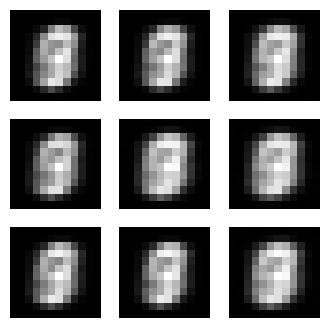

Epoch 20 - loss : 301488.19287109375


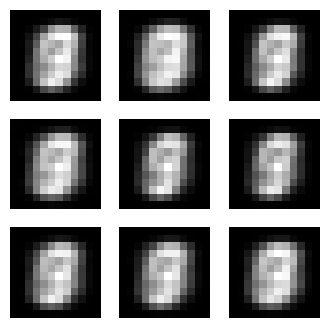

Epoch 30 - loss : 289855.93701171875


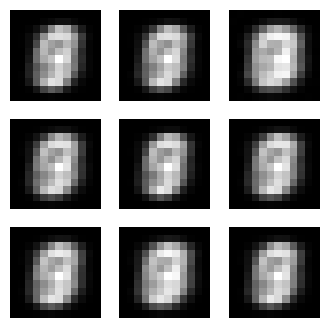

Epoch 40 - loss : 279547.60791015625


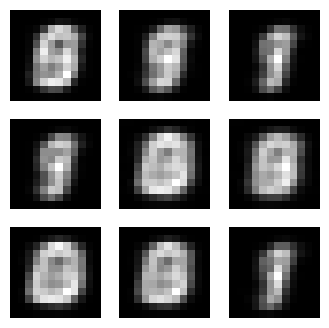

Epoch 50 - loss : 270844.82568359375


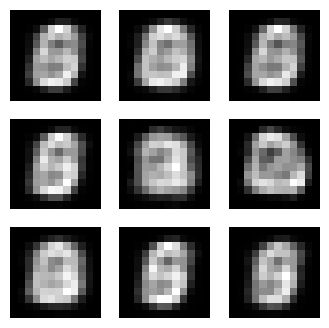

Epoch 60 - loss : 262373.29833984375


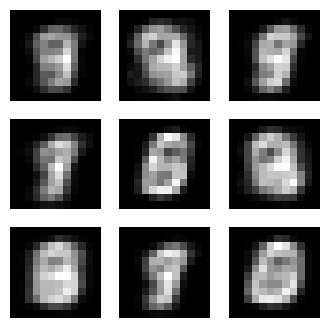

Epoch 70 - loss : 252672.26171875


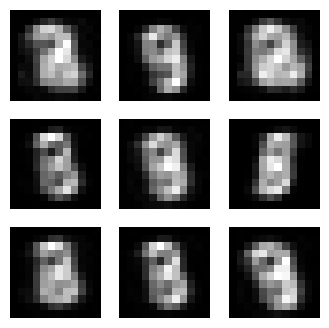

Epoch 80 - loss : 246130.71728515625


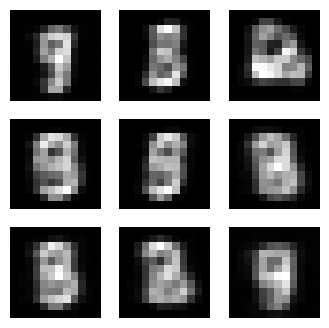

Epoch 90 - loss : 240634.3505859375


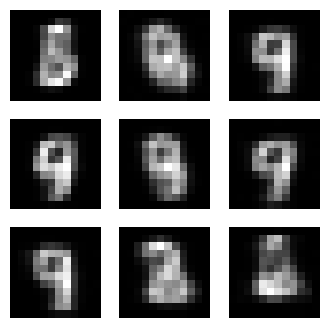

Epoch 100 - loss : 235640.609375


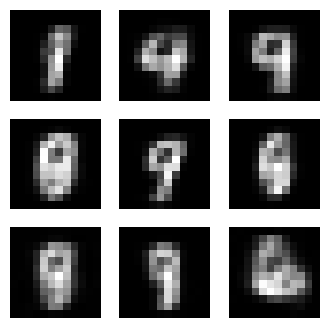

Epoch 110 - loss : 230949.03759765625


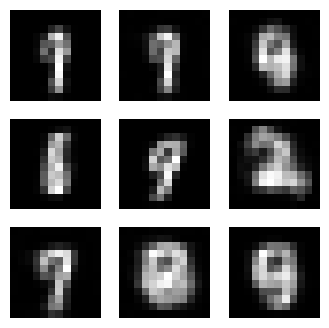

Epoch 120 - loss : 227283.91650390625


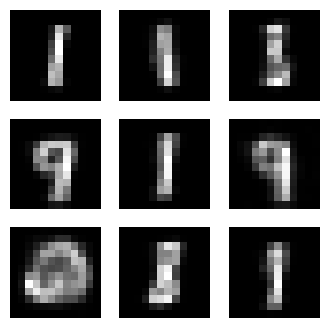

Epoch 130 - loss : 223217.91455078125


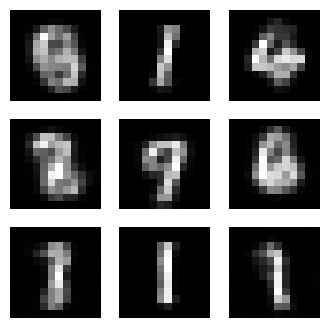

Epoch 140 - loss : 219903.9267578125


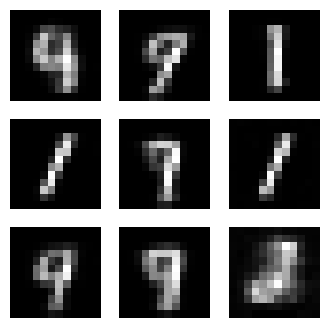

Epoch 150 - loss : 217483.79931640625


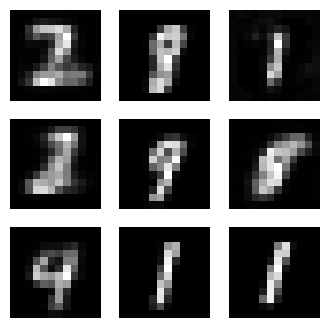

Epoch 160 - loss : 214308.27099609375


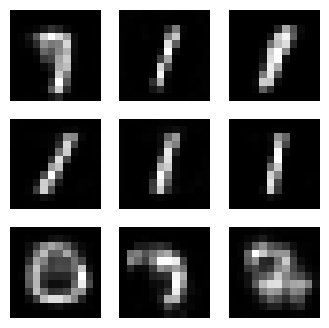

Epoch 170 - loss : 211204.26147460938


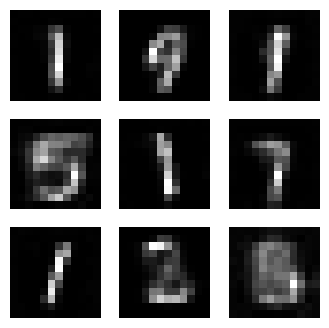

Epoch 180 - loss : 209131.19262695312


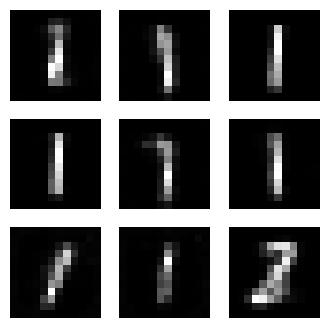

Epoch 190 - loss : 206397.12646484375


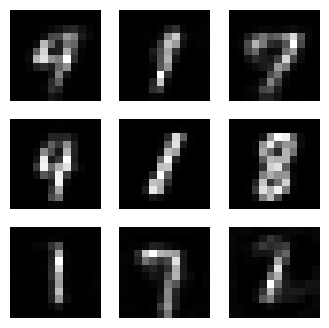

Epoch 200 - loss : 204543.41259765625


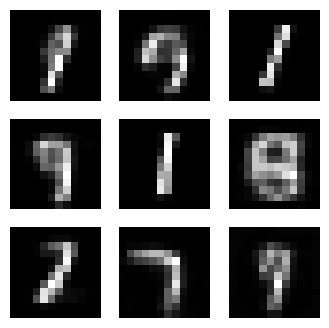

Epoch 210 - loss : 206262.4970703125


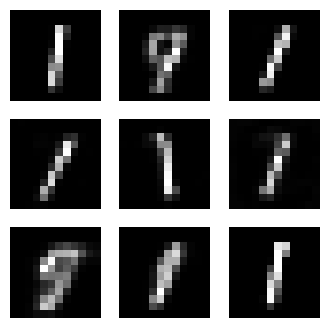

Epoch 220 - loss : 200878.7470703125


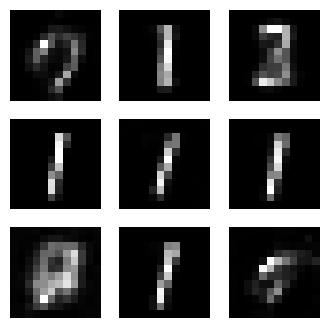

Epoch 230 - loss : 199817.73266601562


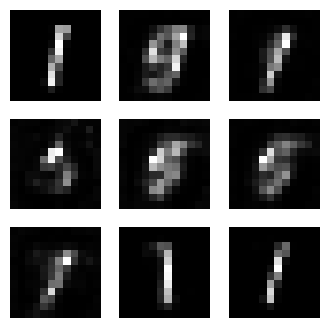

Epoch 240 - loss : 199025.90454101562


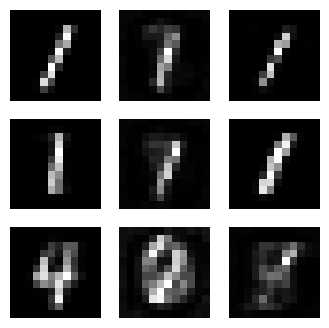

Epoch 250 - loss : 197430.33178710938


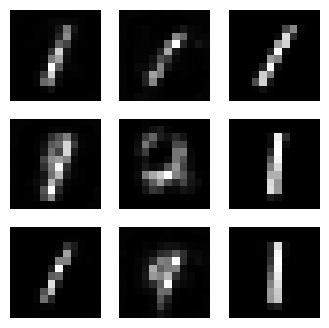

In [25]:
losses = train(model, optimizer=optimizer, epochs=250, device=device)

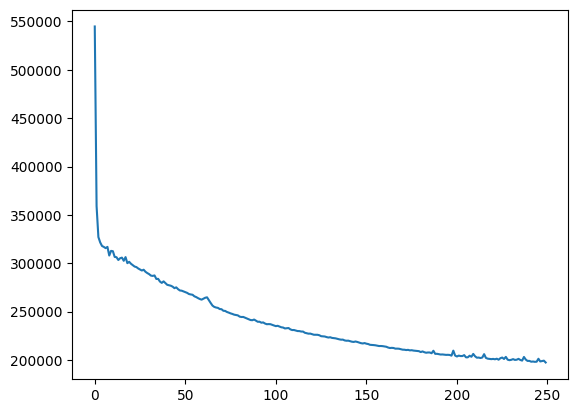

In [26]:
plt.plot(losses)
plt.show()